In [8]:
import numpy as np
import matplotlib.pyplot as plt

class ODESolver:
    def __init__(self, f):
        # Wrap user's f in a new function that always
        # converts list/tuple to array (or let array be array)
        self.model = f
        self.f = lambda t, u: np.asarray(f(t, u), float)

    def set_initial_condition(self, u0):
        if np.isscalar(u0):              # scalar ODE
            self.neq = 1                 # no of equations
            u0 = float(u0)
        else:                            # system of ODEs
            u0 = np.asarray(u0)
            self.neq = u0.size           # no of equations
        self.u0 = u0

    def solve(self, t_span, N):
        """Compute solution for
        t_span[0] <= t <= t_span[1],
        using N steps.
        Returns the solution and the 
        time points as arrays. 
        """
        t0, T = t_span
        self.dt = (T - t0) / N
        self.t = np.zeros(N + 1)  # N steps ~ N+1 time points
        if self.neq == 1:
            self.u = np.zeros(N + 1)
        else:
            self.u = np.zeros((N + 1, self.neq))

        msg = "Please set initial condition before calling solve"
        assert hasattr(self, "u0"), msg

        self.t[0] = t0
        self.u[0] = self.u0

        for n in range(N):
            self.n = n
            self.t[n + 1] = self.t[n] + self.dt
            self.u[n + 1] = self.advance()
        return self.t, self.u

    def advance(self):
        raise NotImplementedError(
            "Advance method is not implemented in the base class")



class ForwardEuler(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        return u[n] + dt * f(t[n], u[n])

class Heun(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt, u[n] + dt * k1)
        return u[n] + dt / 2 * (k1 + k2)

class ExplicitMidpoint(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        dt2 = dt / 2.0
        k1 = f(t[n], u[n])
        k2 = f(t[n] + dt2, u[n] + dt2 * k1)
        return u[n] + dt * k2

class RungeKutta4(ODESolver):
    def advance(self):
        u, f, n, t = self.u, self.f, self.n, self.t
        dt = self.dt
        dt2 = dt / 2.0
        k1 = f(t[n], u[n],)
        k2 = f(t[n] + dt2, u[n] + dt2 * k1, )
        k3 = f(t[n] + dt2, u[n] + dt2 * k2, )
        k4 = f(t[n] + dt, u[n] + dt * k3, )
        return u[n] + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


class BackwardEuler(ODESolver):
    def stage_eq(self, k):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        return k - f(t[i] + h, u[i] + h * k)

    def solve_stage(self):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        k0 = f(t[i], u[i])
        sol = root(self.stage_eq, k0)
        return sol.x

    def advance(self):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        k1 = self.solve_stage()
        return u[i] + h * k1


class CrankNicolson(BackwardEuler):
    
    def advance(self):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        k1 = f(t[i], u[i])
        k2 = self.solve_stage()
        return u[i] + h / 2 * (k1 + k2)


class ImplicitMidpoint(ODESolver):
    def stage_eq(self, k):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        return k - f(t[i] + h / 2, u[i] + h / 2 * k)

    def solve_stage(self):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        k0 = f(t[i], u[i])
        sol = root(self.stage_eq, k0)
        return sol.x

    def advance(self):
        t, u, f, i, h = self.t, self.u, self.f, self.i, self.h
        k2 = self.solve_stage()
        return u[i] + h * k2

Iniciando simulações da Equação Logística...
Parâmetros: alpha=2.0, R=100.0, u0=10.0, t_span=[0, 50]
Limite estabilidade (Euler/Heun/Midpoint): h < 1.00
Limite estabilidade (RK4): h < 1.39

--- Executando: h = 0.50 (n=100) ---

--- Executando: h = 0.90 (n=55) ---

--- Executando: h = 1.10 (n=45) ---

--- Executando: h = 1.50 (n=33) ---


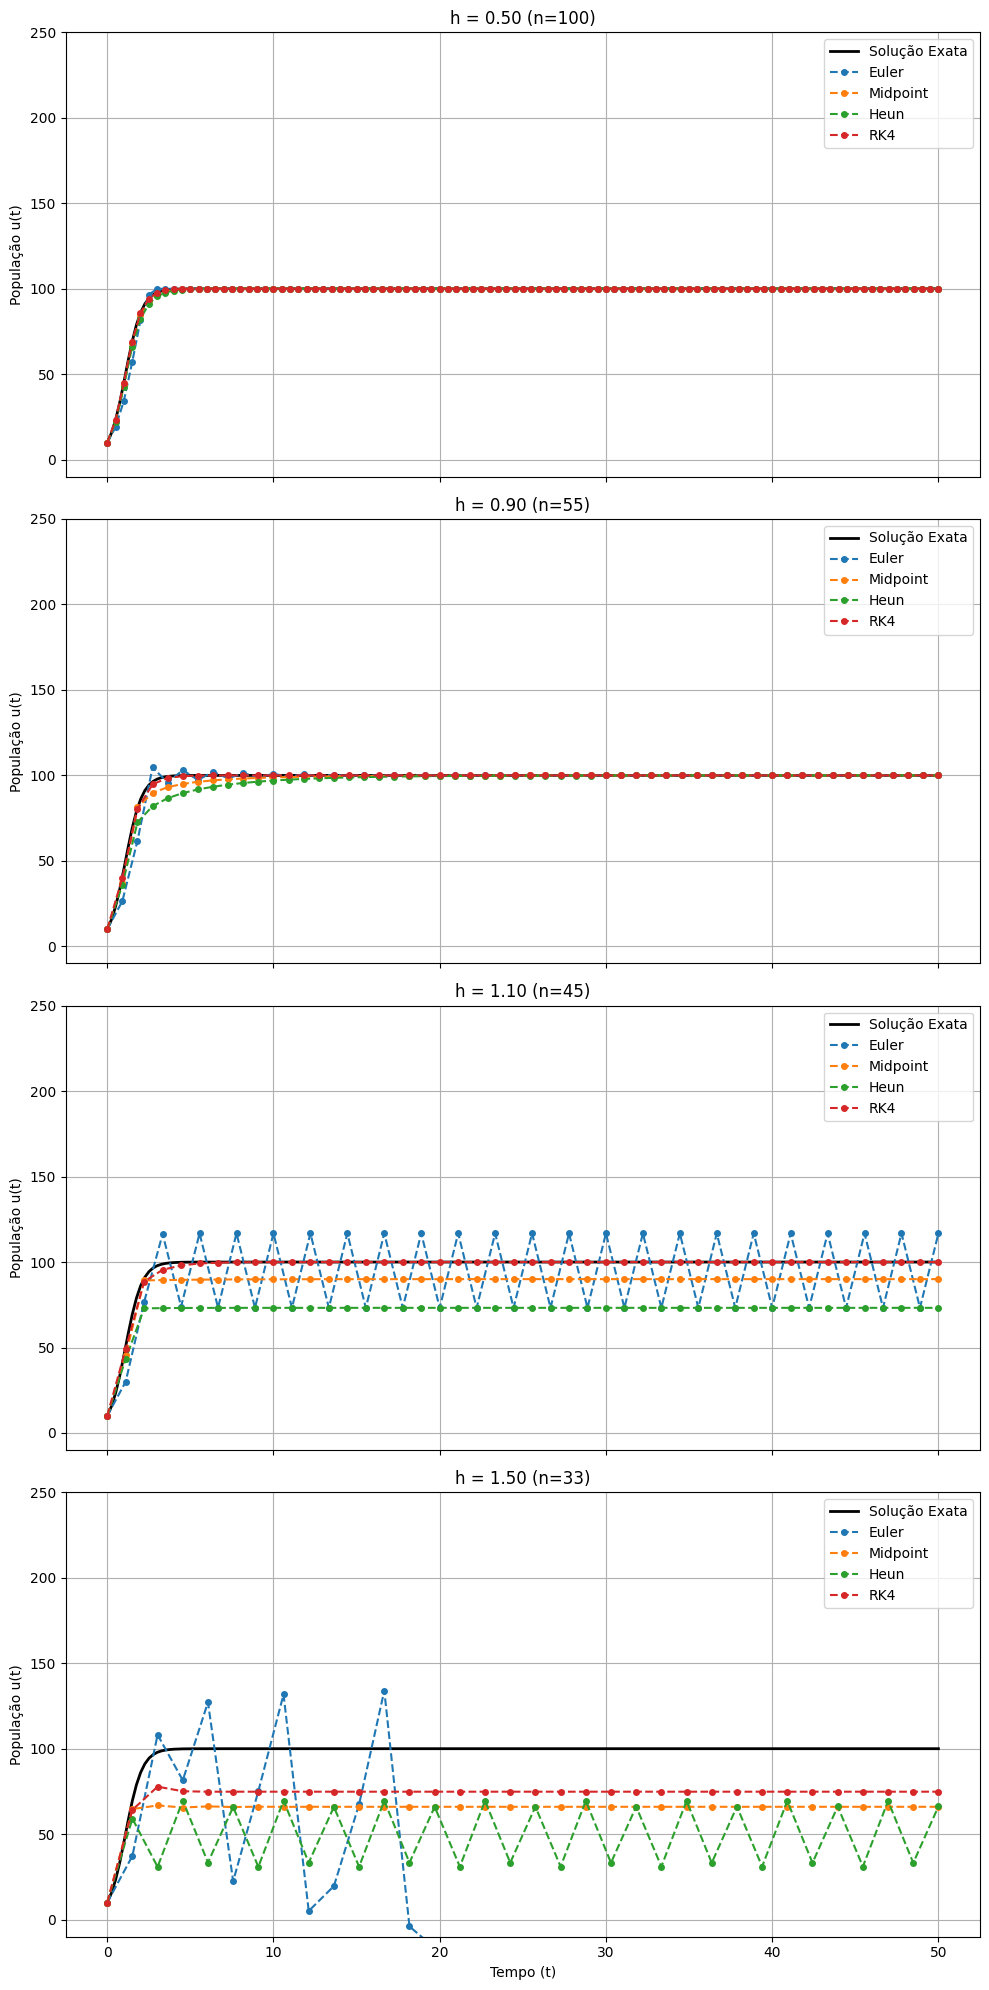

In [9]:
from Logistic import Logistic 


def get_exact_solution(t_points, u0, alpha, R):
    """Calcula a solução analítica da equação logística."""
    if u0 == 0:
        return np.zeros_like(t_points)
    
    # Evita divisão por zero se u0 == R
    if abs(R - u0) < 1e-10:
        return np.full_like(t_points, R)
        
    A = (R / u0) - 1
    if A <= 0: # Caso u0 > R
         # Lida com log de negativo se u0 > R, embora o modelo não devesse começar aí
         # Esta fórmula é a padrão e funciona
         pass

    return R / (1 + A * np.exp(-alpha * t_points))

def run_experiment_logistic():
    """
    Executa a simulação da equação logística para vários métodos
    e passos, plotando os resultados.
    """
    # --- Parâmetros da Simulação ---
    alpha = 2.0  # Taxa de crescimento
    R = 100.0    # Capacidade de suporte
    u0 = 10.0    # Condição inicial
    t_span = [0, 50]
    
    logistic_model = Logistic(alpha=alpha, R=R)
    
    # Métodos a serem testados
    solvers_to_test = [
        ("Euler", ForwardEuler),
        ("Midpoint", ExplicitMidpoint),
        ("Heun", Heun),
        ("RK4", RungeKutta4)
    ]
    
    # Valores de h para testar (cruzando os limites de estabilidade)
    # Limite Euler/RK2: h=1.0. Limite RK4: h=1.39
    h_values = [0.5, 0.9, 1.1, 1.5]

    print("Iniciando simulações da Equação Logística...")
    print(f"Parâmetros: alpha={alpha}, R={R}, u0={u0}, t_span={t_span}")
    print(f"Limite estabilidade (Euler/Heun/Midpoint): h < {2.0/alpha:.2f}")
    print(f"Limite estabilidade (RK4): h < {2.785/alpha:.2f}")

    # Criar uma grade de subplots
    fig, axes = plt.subplots(len(h_values), 1, figsize=(10, 5 * len(h_values)), sharex=True)
    
    if len(h_values) == 1:
        axes = [axes] 

    for ax, h in zip(axes, h_values):
        n_steps = int((t_span[1] - t_span[0]) / h)
        title = f"h = {h:.2f} (n={n_steps})"
        print(f"\n--- Executando: {title} ---")
        ax.set_title(title)
        
        # 1. Plotar Solução Exata
        t_exact = np.linspace(t_span[0], t_span[1], 200)
        u_exact = get_exact_solution(t_exact, u0, alpha, R)
        ax.plot(t_exact, u_exact, 'k-', label="Solução Exata", linewidth=2)
        
        # 2. Executar e Plotar cada solver numérico
        for name, solver_class in solvers_to_test:
            solver = solver_class(logistic_model)
            solver.set_initial_condition(u0)
            
            t, u = solver.solve(t_span, n_steps)
            
            # Limita o eixo Y para não explodir o gráfico
            u_clipped = np.clip(u, -0.5 * R, 1.5 * R) 
            
            ax.plot(t, u_clipped, 'o--', label=name, markersize=4)
        
        ax.set_ylabel("População u(t)")
        ax.legend()
        ax.grid(True)
        ax.set_ylim(-10, R * 2.5) # Define um limite de Y razoável

    axes[-1].set_xlabel("Tempo (t)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment_logistic()
